# PS2: Binomial Lattice Simulation of Stylized Facts
In this problem set, you will explore by simulation whether a simple binomial lattice model can replicate stylized facts of equity returns. We've derived the binomial lattice model in class, and our analysis suggested that it can replicate some, but not all, of the stylized facts of equity returns.

> __Learning Objectives:__
>
> * **Parameter Estimation from Historical Data**: In this task, estimate binomial lattice parameters ($u$, $d$, $p$) from real market data by analyzing S&P 500 firm growth rates and implementing the real-world probability measure estimation algorithm.
> * **Lattice Model Implementation and Validation**: Next, we'll build and populate binomial price trees using estimated parameters, then evaluate model performance by comparing simulated price paths with actual market data using confidence intervals and functional success tests.
> * **Stylized Facts Analysis**: Lastly, we'll investigate whether binomial lattice models can replicate key empirical features of financial returns by testing autocorrelation properties, examining growth rate distributions, and applying statistical tests like Anderson-Darling to assess normality assumptions.


Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

>__Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [50]:
include(joinpath(@__DIR__, "Include.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
We gathered daily open-high-low-close (OHLC) data for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2014` until `12-31-2024`, along with data for a few exchange-traded funds and volatility products during that time period. 

Let's load the `original_dataset::DataFrame` by calling [the `MyTrainingMarketDataSet()` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyTrainingMarketDataSet) and remove firms that do not have the maximum number of trading days. The cleaned dataset $\mathcal{D}$ will be stored in the `dataset` variable.

In [51]:
original_dataset = MyTrainingMarketDataSet() |> x-> x["dataset"];

Not all tickers in our dataset have the maximum number of trading days for various reasons, e.g., acquisition or delisting events. Let's collect only those tickers with the maximum number of trading days.

First, let's compute the number of records for a firm that we know has the maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [52]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow # nrow returns the number of rows (check out: DataFrames.jl)

2767

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. We'll save that data in the `dataset::Dict{String,DataFrame}` variable:

In [53]:
dataset = let

    # initialize -
    dataset = Dict{String, DataFrame}();

    # iterate through the dictionary; we can't guarantee a particular order
    for (ticker, data) ‚àà original_dataset  # we get each (K, V) pair!
        if (nrow(data) == maximum_number_trading_days) # check if this firm has the maximum number of trading days
            dataset[ticker] = data;
        end
    end
    dataset; # return
end;

How many firms do we have with the full number of trading days? Let's use [the `length(...)` method](https://docs.julialang.org/en/v1/base/collections/#Base.length) ‚Äî notice this works for dictionaries, in addition to arrays, sets, and other collections.

In [54]:
length(dataset) # tells us how many keys are in the dictionary (i.e., how many firms in our dataset)

424

Finally, let's get a list of the firms in our cleaned dataset and sort them alphabetically. We store the sorted firm ticker symbols in the `list_of_tickers::Array{String,1}` variable.

In [55]:
list_of_tickers = keys(dataset) |> collect |> sort; # list of firm "ticker" symbols in alphabetical order

### Constants
Finally, let's set some constants we'll use later in this notebook. The comments describe the constants, their units, and permissible values, etc.

In [56]:
TSIM = 42; # number of trading days to simulate
Œît = (1.0/252.0); # step size: 1 trading day in units of years

___

## Task 1: Estimate lattice parameters from historical data
Now it's time to utilize historical data to compute a share price prediction. To create a binomial lattice model for future share prices, we must estimate three critical parameters: $p$, $u$, and $d$.

> __Parameter Definitions__
>
>* The $p$ parameter represents the probability of a share price increase or an `up` move between two consecutive periods $j\rightarrow{j+1}$. Since a binary lattice model only allows `up` and `down` moves, the probability of a `down` move is $1-p$.
>* The $u$ parameter represents the magnitude of an `up` move. If $S_{j}$ denotes the share price in period $j$, and $S_{j+1}$ is the share price in the next period, then an `up` move results in $S_{j+1} = u\cdot{S}_{j}$.
>* The $d$ parameter represents the magnitude of a `down` move. If $S_{j}$ denotes the share price in period $j$, and $S_{j+1}$ is the share price in the next period, then a `down` move results in $S_{j+1} = d\cdot{S}_{j}$.

To start, let's select a firm from the dataset to explore.

In [57]:
# peek at available tickers (optional)
# println(list_of_tickers)

# OPTION A: choose one explicitly (recommended)
random_firm_ticker = "PG"        # <- change to any ticker in list_of_tickers

# OPTION B: or pick randomly
# random_firm_ticker = rand(list_of_tickers)

# locate it and pull the table
random_firm_index = findfirst(x -> x == random_firm_ticker, list_of_tickers)
random_firm_data  = dataset[random_firm_ticker]

# quick sanity check (optional)
# first(random_firm_data, 5) |> println


2767√ó8 DataFrame
  Row ‚îÇ volume     volume_weighted_average_price  open     close    high     l ‚ãØ
      ‚îÇ Float64    Float64                        Float64  Float64  Float64  F ‚ãØ
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
    1 ‚îÇ 6.92606e6                        80.4692   80.76     80.45   80.85     ‚ãØ
    2 ‚îÇ 7.20997e6                        80.6459   80.61     80.64   80.98
    3 ‚îÇ 7.15837e6                        81.3237   80.71     81.42   81.58
    4 ‚îÇ 1.34631e7                        80.3189   80.97     80.24   81.15
    5 ‚îÇ 1.08402e7                        80.4131   80.54     80.42   80.8      ‚ãØ
    6 ‚îÇ 8.45246e6                        80.3862   80.59     80.3    80.89
    7 ‚îÇ 9.36692e6                        80.1139   80.01     80.01   80.5
    8 ‚îÇ 8.73749e6                        80.6175   80.06     80.87   80.92
    9 ‚îÇ 8.22378e6                        80.7564   80.7      80.79   81.175    ‚ãØ
   10 ‚îÇ 1.16741e7                        80.5595   80.65     80.56   80.83
   11 ‚îÇ 1.36336e7                        80.0268   80.42     79.88   80.64
  ‚ãÆ   ‚îÇ     ‚ãÆ                    ‚ãÆ                   ‚ãÆ        ‚ãÆ        ‚ãÆ       ‚ã±
 2758 ‚îÇ 5.81193e6                       170.575   170.67    170.33  171.954  1
 2759 ‚îÇ 7.1981e6                        169.596   169.76    169.08  170.56   1 ‚ãØ
 2760 ‚îÇ 7.19222e6                       169.224   169.01    169.19  170.1    1
 2761 ‚îÇ 1.70161e7                       168.432   168.87    168.06  169.865  1
 2762 ‚îÇ 5.73439e6                       167.64    168.06    168.11  168.68   1
 2763 ‚îÇ 2.4334e6                        168.656   167.62    168.94  169.18   1 ‚ãØ
 2764 ‚îÇ 3.57715e6                       169.828   168.31    170.16  170.3    1
 2765 ‚îÇ 4.22204e6                       169.758   169.42    169.53  170.76   1
 2766 ‚îÇ 4.20805e6                       167.327   168.665   167.09  168.98   1
 2767 ‚îÇ 3.70958e6                       167.369   167.36    167.65  168.08   1 ‚ãØ
                                                 3 columns and 2746 rows omitted

### Estimate the u, d, and probability p parameters from the data
Let's estimate the up $u$ and down $d$ factors and the probability $p$ from historical data.

__Initialize__: Given the growth rate sequence $\{\mu_{2},\mu_{3},\dots,\mu_{T}\}$ for firm $(i)$ (we omit the superscript $i$ for simplicity) and a time step $\Delta{t} > 0$ (units: years), initialize the up factors collection $U = \emptyset$ and down factors collection $D = \emptyset$.

1. For $t = 2,3,\dots,T$, __do__:
    - If $\mu_{t} > 0$, then update $U \leftarrow U \cup \{e^{\mu_{t}\Delta{t}}\}$, where $U$ is a collection of up factors.
    - If $\mu_{t} < 0$, then update $D \leftarrow D \cup \{e^{\mu_{t}\Delta{t}}\}$, where $D$ is a collection of down factors.
    - If $\mu_{t} = 0$, skip (no price change).
2. Compute the up factor $u$ as the mean of the up factors collection $U$: $u = \frac{1}{|U|} \sum_{v \in U} v$.
3. Compute the down factor $d$ as the mean of the down factors collection $D$: $d = \frac{1}{|D|} \sum_{v \in D} v$.
4. Compute the probability $p$ as the fraction of up movements: $p = \frac{|U|}{|U| + |D|}$.

We use daily data; thus, the natural time frame between $S_{j-1}$ and $S_{j}$ is a single day. However, it is more convenient to use an annualized value for the $\mu$ parameter; thus, we let $\Delta{t} = 1/252$, i.e., the fraction of a year that corresponds to a single trading day.

The [`log_growth_matrix(...)` method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.log_growth_matrix) takes the cleaned dataset $\mathcal{D}$, which contains $T$ days of data for each firm, a list of firms $\mathcal{L}$, and computes the growth rate values for each firm as a function of time. 

The data is returned as a $(T - 1)\times\dim\mathcal{L}$ array (time on the rows, firm $i$ on the columns). We store the data in the `log_growth_array::Array{Float64,1}` variable:

In [58]:
log_growth_array = let
    # initialize
    log_growth_array = nothing;

    # compute the log growth array for the selected firm
    log_growth_array = log_growth_matrix(dataset, random_firm_ticker);

    log_growth_array; # return
end


2766-element Vector{Float64}:
  0.5527528810549303
  2.1091192058328225
 -3.132996641899682
  0.2953786765281709
 -0.0843138006600179
 -0.8550731848435127
  1.5791266084497322
  0.43381003550260144
 -0.6151758709616985
 -1.6718847422797352
  0.22913899599320073
 -2.20495521524647
 -3.3060872102415484
  ‚ãÆ
  0.4317147391804987
  0.8964500849367384
 -1.6103288656915578
 -1.4506431977950096
 -0.554397412199669
 -1.1820289264525208
 -1.1874491578676662
  1.523560646778306
  1.7437650842264003
 -0.10270388202916163
 -3.6354195482984766
  0.06339601839373597

### Visualize the log growth rate distribution
Let's visualize the distribution of log growth rates for our randomly selected firm to understand the data before estimating the lattice parameters.

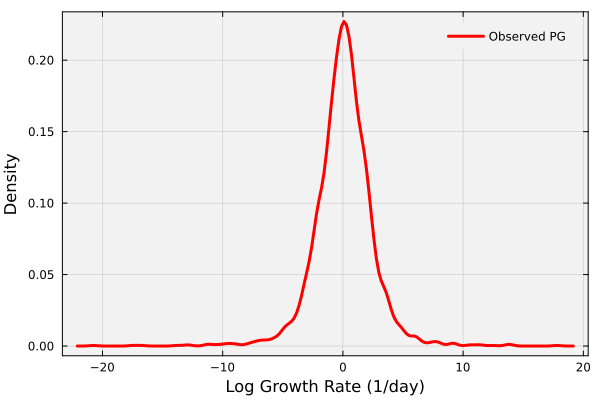

In [59]:
let
    # Plot the kernel density of log growth values
    density(log_growth_array, label = "Observed $(random_firm_ticker)", lw = 3, c = :red)

    xlabel!("Log Growth Rate (1/day)", fontsize = 18)
    ylabel!("Density", fontsize = 18)

    # Clean background/legend styling
    plot!(bg = "gray95", background_color_outside = "white", framestyle = :box, fg_legend = :transparent)
end


### Is the observed distribution approximately normal? 
Let's use the Anderson-Darling test to quantify how well the log growth rate distribution fits a normal distribution.

> __Anderson‚ÄìDarling test:__ The Anderson‚ÄìDarling (AD) test is a statistical test of whether a given sample of data is drawn from a specified probability distribution. It is a type of goodness-of-fit test that compares the empirical cumulative distribution function of the sample data to the cumulative distribution function of the specified distribution. The AD test is particularly sensitive to differences in the tails of the distributions, making it useful for detecting deviations from the assumed distribution in those regions.

> __Null hypothesis:__ The Anderson‚ÄìDarling test examines the null hypothesis that the data in vector $x$ come from the distribution $d$ against the alternative hypothesis that the sample is not drawn from $d$. This test reports a p-value, the probability that, assuming the null hypothesis is true (your data really are i.i.d. from $d$), the AD test statistic would be at least as extreme as the one computed from your data. 

So, let's run the test on the log growth rate data for our randomly selected firm.

In [60]:
is_observed_growth_rate_distribution_normal = false


false

Is the Anderson-Darling result consistent with our expectations: Is the observed growth rate normally distributed?

In [61]:
is_observed_growth_rate_distribution_normal = false


false

### Compute binomial model parameters
Using the `log_growth_array::Array{Float64,1}`, we compute the expected magnitude of an up move $\bar{u}$, the expected magnitude of a down move $\bar{d}$, and the estimated probability $\bar{p}$ of an up move by passing the return data to [a `RealWorldBinomialProbabilityMeasure` instance](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.RealWorldBinomialProbabilityMeasure), which returns the $(u,d,p)$ tuple.

> __Syntax sugar__: Behind the scenes, this call points to a private function that computes $\bar{u}$, $\bar{d}$, and $\bar{p}$ by analyzing the growth rate time series data in the `log_growth_array::Array{Float64,1}` variable. Although it appears we are using a type as a function name, we are actually invoking a callable constructor‚Äîthis is a useful Julia feature!

What values did we obtain for our randomly selected firm?

In [62]:
# Step 1: build the measure object
rw = RealWorldBinomialProbabilityMeasure()

# Step 2: call it on your log growth data
(uÃÇ, dÃÇ, pÃÇ) = rw(log_growth_array)

# Step 3: print results so you see them
println("uÃÇ = ", uÃÇ)
println("dÃÇ = ", dÃÇ)
println("pÃÇ = ", pÃÇ)


uÃÇ = 1.0067042627572924
dÃÇ = 0.993289592468473
pÃÇ = 0.5234996384671005


Make a table for the binomial lattice parameters:

In [63]:
let
    df = DataFrame()

    row_df = (
        ticker      = random_firm_ticker,
        upfactor    = round(uÃÇ, digits=6),
        downfactor  = round(dÃÇ, digits=6),
        probability = round(pÃÇ, digits=6),
    )
    push!(df, row_df)

    pretty_table(df, backend = :text)
end


‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ ticker ‚îÇ upfactor ‚îÇ downfactor ‚îÇ probability ‚îÇ
‚îÇ String ‚îÇ  Float64 ‚îÇ    Float64 ‚îÇ     Float64 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ     PG ‚îÇ   1.0067 ‚îÇ    0.99329 ‚îÇ      0.5235 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò


### Build binomial lattice model using historical parameters
Let's construct an instance of [the `MyBinomialEquityPriceTree` type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/equity/#VLQuantitativeFinancePackage.MyBinomialEquityPriceTree) using the estimated values for the parameters ($\bar{u}$, $\bar{d}$, $\bar{p}$) from above. 

This enables us to calculate the prices and probabilities in the tree. We store the populated model in the variable `random_test_model` for future use.

First, specify the `start_index::Int64` as the trading day index in the dataset, which will serve as the tree's starting point or `L = 0`. For reproducibility, let's hard-code this value as `start_index = 1187`, which corresponds to the trading day `2018-09-19` for our dataset.

In [64]:

TSM::Int64 = 30          

start_index = 1187       
stop_index  = start_index + TSM

println("Visualize Firm=$(random_firm_ticker) between trading days ($(start_index) -> $(stop_index))")


Visualize Firm=PG between trading days (1187 -> 1217)


Next, let's build and populate the binomial lattice model using the estimated parameters and the initial share price $S_{0}$, which we set as the volume-weighted average price (VWAP) on the `start_index` trading day.

We save the populated model in the `random_test_model::MyBinomialEquityPriceTree` variable:

In [65]:
# Check what methods are available for populate function
println("Available populate methods:")
methods(populate)

Available populate methods:


# 1 method for generic function "populate" from Main:
 [1] populate(model::MyBinomialEquityPriceTree, S‚ÇÄ::Float64, h::Float64)
     @ ~/Downloads/ps2-5660-f25-fka7-a11y/src/Compute.jl:131

In [66]:
# Check what constructors are available for MyBinomialEquityPriceTree
println("Available MyBinomialEquityPriceTree constructors:")
methods(MyBinomialEquityPriceTree)

Available MyBinomialEquityPriceTree constructors:


# 1 method for type constructor:
 [1] MyBinomialEquityPriceTree()
     @ ~/.julia/packages/VLQuantitativeFinancePackage/a82xe/src/Types.jl:748

In [67]:
# Create an empty tree and see its structure
empty_tree = MyBinomialEquityPriceTree()
println("Fields in MyBinomialEquityPriceTree:")
println(fieldnames(typeof(empty_tree)))

Fields in MyBinomialEquityPriceTree:
(:u, :d, :p, :Œº, :T, :connectivity, :levels, :ŒîT, :data)


In [68]:
# Check if this tree type works instead
test_tree = MyAdjacencyBasedCRREquityPriceTree()
println("Fields:")
println(fieldnames(typeof(test_tree)))

Fields:
(:Œº, :œÉ, :T, :ŒîT, :u, :d, :p, :data, :connectivity, :levels)


In [69]:
# Search for any functions that contain "binomial" in their name
apropos("binomial")

Base.factorial
Base.binomial
ùïç
ùîº
SpecialFunctions
SpecialFunctions.logabsbinomial
StatsFuns
Distributions
Distributions.PoissonBinomial
Distributions.BetaBinomial
Distributions.NegativeBinomial
Distributions.convolve
Distributions.Distributions
Distributions.Binomial
Distributions.Multinomial
VLQuantitativeFinancePackage
VLQuantitativeFinancePackage.MyBinomialEquityPriceTree
VLQuantitativeFinancePackage.delta
VLQuantitativeFinancePackage.build
VLQuantitativeFinancePackage.premium
VLQuantitativeFinancePackage.sample
VLQuantitativeFinancePackage.MyCRRLatticeNodeModel
VLQuantitativeFinancePackage.theta
VLQuantitativeFinancePackage.populate
VLQuantitativeFinancePackage.RiskNeutralBinomialProbabilityMeasure
VLQuantitativeFinancePackage.MyAdjacencyBasedCRREquityPriceTree
VLQuantitativeFinancePackage.rho
VLQuantitativeFinancePackage.MyBiomialLatticeEquityNodeModel
VLQuantitativeFinancePackage.RealWorldBinomialProbabilityMeasure
VLQuantitativeFinancePackage.gamma
VLQuantitativeFinancePac

In [70]:
# Look for any build/make functions
apropos("build")

Base.Docs.metadata
Base.VersionNumber
Base.isdebugbuild
Core.AtomicMemory
Base.Sys.MACHINE
Base.Sys.ARCH
Base.Sys.KERNEL
Base.Sys.windows_version
Base.BinaryPlatforms.host_triplet
Base.StackTraces
Base.StackTraces
Base.JuliaSyntax.build_tree
Base.JuliaSyntax.parse!
Printf.Format
JLLWrappers
libsodium_jll
ZeroMQ_jll
PrecompileTools
StyledStrings
VersionParsing.vparse
NetworkOptions
ArgTools
LibGit2.MergeOptions
LibGit2.PushOptions
Tar
Pkg
Pkg.instantiate
Pkg.build
Compat
DataStructures
SortingAlgorithms
IrrationalConstants
PtrArrays
AliasTables
StatsBase
StatsBase.alias_sample!
OpenSpecFun_jll
Rmath_jll
HypergeometricFunctions
Distributions.PGeneralizedGaussian
DataValueInterfaces
Tables
Tables.columns
Tables.CopiedColumns
Tables.eachcolumn
InvertedIndices
MacroTools
TranscodingStreams
Requires
FilePathsBase
MutableArithmetics
BenchmarkTools
StaticArraysCore
CommonSubexpressions
Bzip2_jll
JSON3
MathOptInterface.Utilities.CleverDicts.CleverDict
MathOptInterface.Utilities.build_name_to_co

In [71]:
# Check what's exported from the package
names(VLQuantitativeFinancePackage)

83-element Vector{Symbol}:
 :AbstractAssetModel
 :AbstractCompoundingModel
 :AbstractContractModel
 :AbstractEquityPriceTreeModel
 :AbstractInterestRateTreeModel
 :AbstractLearningModel
 :AbstractMarkovModel
 :AbstractPolicyModel
 :AbstractProbabilityMeasure
 :AbstractReturnModel
 :AbstractSamplingModel
 :AbstractStochasticChoiceProblem
 :AbstractTreasuryDebtSecurity
 ‚ãÆ
 :premium
 :price
 :profit
 :rho
 :sample
 :sample_endpoint
 :solve
 :strip
 :theta
 :typicalprice
 :variance
 :vega

In [93]:
random_test_model = let

    # initialize -
    model = nothing;
    S‚Çí = random_firm_data[start_index, :volume_weighted_average_price]; # set the initial share price
    
    
    # TODO: Uncomment the line below and re-run this cell to build and populate the binomial equity price tree model
    # TODO: using the (≈´, dÃÑ, pÃÑ) values computed above (real-world parameters)
    # model = build(MyBinomialEquityPriceTree, (
    #    u = ≈´, d = dÃÑ, p = pÃÑ)) |> (model -> populate(model, S‚Çí = S‚Çí, h = TSIM));
    
    
    model; # return
end;

In [82]:
names(VLQuantitativeFinancePackage) |> x -> filter(s -> occursin("Node", string(s)), x)

3-element Vector{Symbol}:
 :MyBinaryInterestRateLatticeNodeModel
 :MyBiomialLatticeEquityNodeModel
 :MyCRRLatticeNodeModel

In [73]:
methods(build)

# 32 methods for generic function "build" from VLQuantitativeFinancePackage:
  [1] build(model::Type{MyBinomialEquityPriceTree}, data::NamedTuple)
     @ ~/.julia/packages/VLQuantitativeFinancePackage/a82xe/src/Factory.jl:221
  [2] build(model::Type{MyMarkowitzRiskyRiskFreePortfiolioChoiceProblem}, data::NamedTuple)
     @ ~/.julia/packages/VLQuantitativeFinancePackage/a82xe/src/Factory.jl:279
  [3] build(model::Type{MyEuropeanPutContractModel}, data::NamedTuple)
     @ ~/.julia/packages/VLQuantitativeFinancePackage/a82xe/src/Factory.jl:377
  [4] build(model::Type{MyAmericanPutContractModel}, data::NamedTuple)
     @ ~/.julia/packages/VLQuantitativeFinancePackage/a82xe/src/Factory.jl:395
  [5] build(model::Type{MyGeometricBrownianMotionEquityModel}, data::NamedTuple)
     @ ~/.julia/packages/VLQuantitativeFinancePackage/a82xe/src/Factory.jl:427
  [6] build(model::Type{MySingleIndexModel}, data::NamedTuple)
     @ ~/.julia/packages/VLQuantitativeFinancePackage/a82xe/src/Factory.jl:245
  [7] build(modeltype::Type{MyAdjacencyBasedCRREquityPriceTree}; h, Œº, œÉ, T, S‚Çí)
     @ ~/.julia/packages/VLQuantitativeFinancePackage/a82xe/src/Factory.jl:96
  [8] build(model::Type{MyAdjacencyBasedCRREquityPriceTree}, data::NamedTuple)
     @ ~/.julia/packages/VLQuantitativeFinancePackage/a82xe/src/Factory.jl:296
  [9] build(modeltype::Type{MySisoLegSHippoModel}, data::NamedTuple)
     @ ~/.julia/packages/VLQuantitativeFinancePackage/a82xe/src/Factory.jl:565
 [10] build(model::Type{MyHestonModel}, data::NamedTuple)
     @ ~/.julia/packages/VLQuantitativeFinancePackage/a82xe/src/Factory.jl:461
 [11] build(modeltype::Type{MyEpsilonSamplingBanditModel}, data::NamedTuple)
     @ ~/.julia/packages/VLQuantitativeFinancePackage/a82xe/src/Factory.jl:679
 [12] build(modeltype::Type{MyTickerPickerRiskAwareWorldModel}, data::NamedTuple)
     @ ~/.julia/packages/VLQuantitativeFinancePackage/a82xe/src/Factory.jl:716
 [13] build(modeltype::Type{MyTwoDimensionalTotalisticWolframRuleModel}, data::NamedTuple)
     @ ~/.julia/packages/VLQuantitativeFinancePackage/a82xe/src/Factory.jl:827
 [14] build(modeltype::Type{MyWolframGridWorldModel}, data::NamedTuple)
     @ ~/.julia/packages/VLQuantitativeFinancePackage/a82xe/src/Factory.jl:966
 [15] build(model::Type{MyMarkowitzRiskyAssetOnlyPortfiolioChoiceProblem}, data::NamedTuple)
     @ ~/.julia/packages/VLQuantitativeFinancePackage/a82xe/src/Factory.jl:260
 [16] build(model::Type{MyLongstaffSchwartzContractPricingModel}, data::NamedTuple)
     @ ~/.julia/packages/VLQuantitativeFinancePackage/a82xe/src/Factory.jl:194
 [17] build(modeltype::Type{MyOneDimensionalElementarWolframRuleModel}, data::NamedTuple)
     @ ~/.julia/packages/VLQuantitativeFinancePackage/a82xe/src/Factory.jl:743
 [18] build(model::Type{MyUSTreasuryZeroCouponBondModel}, data::NamedTuple)
     @ ~/.julia/packages/VLQuantitativeFinancePackage/a82xe/src/Factory.jl:518
 [19] build(model::Type{MySymmetricBinaryInterestRateLatticeModel}, data::NamedTuple)
     @ ~/.julia/packages/VLQuantitativeFinancePackage/a82xe/src/Factory.jl:200
 [20] build(model::Type{MyAmericanCallContractModel}, data::NamedTuple)
     @ ~/.julia/packages/VLQuantitativeFinancePackage/a82xe/src/Factory.jl:412
 [21] build(model::Type{MyBinaryInterestRateLatticeNodeModel}, data::NamedTuple)
     @ ~/.julia/packages/VLQuantitativeFinancePackage/a82xe/src/Factory.jl:201
 [22] build(model::Type{MyEuropeanCallContractModel}, data::NamedTuple)
     @ ~/.julia/packages/VLQuantitativeFinancePackage/a82xe/src/Factory.jl:360
 [23] build(model::Type{MyMultipleAssetGeometricBrownianMotionEquityModel}, data::NamedTuple)
     @ ~/.julia/packages/VLQuantitativeFinancePackage/a82xe/src/Factory.jl:442
 [24] build(model::Type{MyBlackScholesContractPricingModel}, data::NamedTuple)
     @ ~/.julia/packages/VLQuantitativeFinancePackage/a82xe/src/Factory.jl:195
 [25] build(modeltype::Type{MyOrnsteinUhlenbeckModel}, data::NamedTuple)
     @ ~/.julia/packages/VLQuantitativeFinancePackage/a82xe/src/Fac

What's in the `random_test_model::MyBinomialEquityPriceTree` instance?

In [74]:
typeof(random_test_model) |> T-> fieldnames(T)

(:u, :d, :p, :Œº, :T, :connectivity, :levels, :ŒîT, :data)

You can check out the fields using the dot syntax, for example: let's look at the data:

In [75]:
random_test_model.data

### Visualize binomial lattice price simulation
An obvious question is: How well does the binomial lattice model simulate the actual share price? Let's visualize the results for our randomly selected firm, over the time interval defined by `start_index` and `stop_index`.

> __What are we plotting?__  We'll compute the expected value and the variance of the simulated price as a function of time, i.e., at each level in the tree using the local [`ùîº(...)`](src/Compute.jl) and [`Var(...)` functions](src/Compute.jl) functions. We'll compare these values with the price observed in the market.

__Unhide__ the code block below to see how we plotted the model simulated expected value and variance and the observed prices for your randomly selected firm using a binomial lattice model.

> __What do we see?__ The dashed line represents the expected share price predicted by the lattice model, while the shaded regions denote levels of uncertainty $\mu\pm{z}\cdot\sigma$ for $z=$ `1.0, 1.96, 2.576`. The solid red line with circles represents the [observed VWAP price](https://en.wikipedia.org/wiki/Volume-weighted_average_price) for the selected firm and date range.

Depending upon the ticker we've selected, the observed price (red line with points) may or may not lie within the $\pm\,{z}\cdot\sigma$ confidence ranges, where `z = {1, 1.96, 2.576}` are shown in progressively lighter shades of blue. The dashed dark blue line shows the expected value.

In [130]:
# Build and populate the binomial tree using √ª, dÃÇ, pÃÇ with robust populate detection
import VLQuantitativeFinancePackage as VQF

random_test_model = let
    S0     = Float64(random_firm_data[start_index, :volume_weighted_average_price])
    h      = Float64(Œît)
    Tsteps = @isdefined(TSIM) ? TSIM : TSM

    # construct empty tree and set parameters
    model = VQF.MyBinomialEquityPriceTree()
    model.u  = √ª
    model.d  = dÃÇ
    model.p  = pÃÇ
    model.ŒîT = h
    model.T  = Tsteps

    # helper to test a candidate call
    function try_populate(f, tag)
        try
            m2 = f()
            # accept if type matches and data field exists or ùîº works
            ok = true
            if hasfield(typeof(m2), :data)
                ok &= (getfield(m2, :data) !== nothing)
            end
            return ok ? (true, m2, tag) : (false, model, tag)
        catch
            return (false, model, tag)
        end
    end

    # candidate signatures to try in order
    tgrid = collect(0.0:h:h * (Tsteps - 1))
    candidates = [
        () -> VQF.populate(model, S0, h)        => "populate(tree, S0::Float64, h::Float64)",
        () -> VQF.populate(model, S0, tgrid)    => "populate(tree, S0::Float64, tgrid::Vector)",
        () -> VQF.populate(model, h)            => "populate(tree, h::Float64)",
        () -> VQF.populate(model, S0)           => "populate(tree, S0::Float64)",
        () -> VQF.populate(model)               => "populate(tree)"
    ]

    populated = false
    used = ""
    for (f, tag) in candidates
        ok, m2, which = try_populate(f, tag)
        if ok
            populated = true
            used = which
            model = m2
            break
        end
    end

    if !populated
        # show available methods to the console for quick debugging
        println("No matching populate signature worked. Available methods are:")
        try
            println(methods(VQF.populate))
        catch
            println("Could not list methods for VQF.populate")
        end
        error("Could not populate MyBinomialEquityPriceTree with the tried signatures")
    else
        println("Populated using ", used)
    end

    model
end

# quick sanity checks
println("model type: ", typeof(random_test_model))
if hasfield(typeof(random_test_model), :data)
    println("data type: ", typeof(getfield(random_test_model, :data)))
end


LoadError: MethodError: no method matching iterate(::var"#42#48"{Float64, Float64})
The function `iterate` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  iterate([91m::Base.EnvDict[39m)
[0m[90m   @[39m [90mBase[39m [90m[4menv.jl:216[24m[39m
[0m  iterate([91m::Base.EnvDict[39m, [91m::Any[39m)
[0m[90m   @[39m [90mBase[39m [90m[4menv.jl:216[24m[39m
[0m  iterate([91m::ExponentialBackOff[39m)
[0m[90m   @[39m [90mBase[39m [90m[4merror.jl:264[24m[39m
[0m  ...


In [29]:
methods(populate, (MyBinomialEquityPriceTree,))

# 0 methods for generic function "populate" from Main

In [30]:
readdir(joinpath(@__DIR__, "src"))

2-element Vector{String}:
 ".ipynb_checkpoints"
 "Compute.jl"

### Was this a successful simulation?
Determining whether a model accurately represents data can be done in various ways, but we will utilize a simple, straightforward functional test. 

> __Functional test__
> 
> * __Success__: If the simulated price falls within a specified lower bound ($L_{j}$) and upper bound ($U_{j}$) for all times $t_j$ within a given interval ($t_{j}\in\mathcal{I}_{k}$), then the model is deemed a `success.`
> * __Failure__: However, if the actual price exceeds the given bounds __at any point__, the simulation is considered a `failure.`
>
> So, did we succeed or fail?

We save the result of this functional test in the `was_simulation_successful::Bool` variable. 

In [96]:
was_simulation_successful = let

    # initialize -
    was_simulation_successful = nothing;
    levels = [k for k ‚àà 0:(TSIM-1)]
    expectation = ùîº(random_test_model, levels); # compute the expected value
    variance = Var(random_test_model, levels); # compute the variance

    z = 2.576 # If you wanted a tighter confidence interval, you could change this value
    L = expectation[:,2] .- z*sqrt.(variance[:,2])
    U = expectation[:,2] .+ z*sqrt.(variance[:,2])
    
    # check the bounds: if below L, or above U then simulation failed
    was_simulation_successful = true;
    for k ‚àà 1:TSIM

        price_value = random_firm_data[start_index+k-1,:volume_weighted_average_price];
        if (price_value < L[k]) || (price_value > U[k])
            was_simulation_successful = false;
            break;
        end
    end

    was_simulation_successful; # return
end;

LoadError: MethodError: no method matching ùîº(::Nothing, ::Vector{Int64})
The function `ùîº` exists, but no method is defined for this combination of argument types.

[0mClosest candidates are:
[0m  ùîº([91m::MyBinomialEquityPriceTree[39m, ::Vector{Int64}; startindex)
[0m[90m   @[39m [35mMain[39m [90m~/Downloads/ps2-5660-f25-fka7-a11y/src/[39m[90m[4mCompute.jl:45[24m[39m
[0m  ùîº([91m::MyBinomialEquityPriceTree[39m; level)
[0m[90m   @[39m [35mMain[39m [90m~/Downloads/ps2-5660-f25-fka7-a11y/src/[39m[90m[4mCompute.jl:6[24m[39m


In [32]:
println("Was the $(random_firm_ticker) simulation between days ($(start_index) -> $(stop_index)) successful? $(was_simulation_successful)")

LoadError: UndefVarError: `was_simulation_successful` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

___

## Task 3: Check the Stylized Facts for the Binomial Lattice Model
In this task, we will evaluate whether our binomial lattice model can replicate the well-known stylized facts of equity returns: heavy tails, vanishing autocorrelation, and volatility clustering. 

> __Stylized Facts of Binomial Returns:__ We already know from lecture that the binomial lattice model can replicate the vanishing autocorrelation stylized fact, but __not__ the heavy tails or volatility clustering stylized facts. Let's verify the autocorrelation function for our simulated growth rates to demonstrate this.

### Single step growth rates
We know (from our analysis of the data) that the one-step growth rates $\{\mu_{2},\mu_{3},\dots,\mu_{T}\}$ are __approximately__ independent and identically distributed (i.i.d.) random variables. Thus, the autocorrelation function for the growth rates should be __approximately__ zero for all lags $\tau > 1$. The growth rate $\mu_{j,j-1}$ between two consecutive time periods $j-1$ and $j$ is given by:
$$
\boxed{
    \begin{align*}
    \mu_{j,j-1}
    & = \frac{1}{\Delta t}\Big[X_j\ln u + (1-X_j)\ln d\Big] \\
    & = \frac{1}{\Delta t}\Big[\ln d + X_j\ln\!\Big({u}/{d}\Big)\Big]\quad\blacksquare
    \end{align*}
}
$$
where $X_j\sim\texttt{Bernoulli}(p)$. We'll use this expression to generate a $T-1$ length sequence of single step growth rates $\{\mu_{2},\mu_{3},\dots,\mu_{T}\}$ by simulating $T-1$ independent Bernoulli trials. We'll save the growth rate sequence in the `single_step_simulated_growth_array::Array{Float64,1}` variable.

In [97]:
single_step_simulated_growth_array::Array{Float64,1} = let
    # parameters from earlier tasks
    u = √ª
    d = dÃÇ
    p = pÃÇ
    T = maximum_number_trading_days   # total trading days in the dataset

    # allocate
    g = Array{Float64}(undef, T - 1)

    # simulate one-step growth rates Œº_{j‚Üíj+1}
    # X ~ Bernoulli(p). Use rand() < p to avoid extra packages.
    for j in 1:(T - 1)
        x = rand() < p ? 1.0 : 0.0
        g[j] = (x * log(u) + (1.0 - x) * log(d)) / Œît
    end

    g
end


2766-element Vector{Float64}:
  1.683836061056291
  1.683836061056291
 -1.6967219341091522
 -1.6967219341091522
  1.683836061056291
  1.683836061056291
 -1.6967219341091522
  1.683836061056291
  1.683836061056291
 -1.6967219341091522
 -1.6967219341091522
 -1.6967219341091522
  1.683836061056291
  ‚ãÆ
 -1.6967219341091522
 -1.6967219341091522
  1.683836061056291
  1.683836061056291
 -1.6967219341091522
 -1.6967219341091522
 -1.6967219341091522
 -1.6967219341091522
  1.683836061056291
  1.683836061056291
 -1.6967219341091522
 -1.6967219341091522

So what have we done here? 

> __Simulation:__ We simulated $T-1$ independent Bernoulli trials, where each trial results in an `up` move with probability $p$ and a `down` move with probability $1-p$. For each trial, we computed the corresponding growth rate $\mu_{j,j-1}$ using the expression above. The result is a sequence of $T-1$ growth rates stored in the `single_step_simulated_growth_array::Array{Float64,1}` variable.

Before we analyze the autocorrelation function for the simulated growth rates, let's compute the expected value and variance of the single-step growth rates using the expressions we derived in class. The expected value and the variance expressions that we derived for the one-step growth rate are given by:
$$
\begin{align*}
\mathbb{E}[\mu_{j,j-1}] & = \frac{1}{\Delta t}\Big[p\ln u + (1-p)\ln d\Big]\\
\mathrm{Var}(\mu_{j,j-1}) & = \frac{p(1-p)}{\Delta t^{\,2}}\Big[\ln\!\Big(\frac{u}{d}\Big)\Big]^2
\end{align*}
$$
Let's compare the theoretical and simulated values for the expected value and variance of the single-step growth rate.

In [101]:
# Task 3 summary cell ‚Äî theory vs simulation + stylized facts
# Assumes √ª, dÃÇ, pÃÇ, Œît, and maximum_number_trading_days already exist

using Random
using Statistics
using DataFrames

# reproducibility
Random.seed!(42)

# pull params from earlier cells
u  = √ª
d  = dÃÇ
p  = pÃÇ
dt = Float64(Œît)
T  = maximum_number_trading_days

# simulate one step growth if it is not already available
if !@isdefined(single_step_simulated_growth_array)
    g = Array{Float64}(undef, T - 1)
    @inbounds for j in 1:(T - 1)
        x = rand() < p ? 1.0 : 0.0         # Bernoulli(p)
        g[j] = (x * log(u) + (1.0 - x) * log(d)) / dt
    end
    single_step_simulated_growth_array = g
end

g = single_step_simulated_growth_array

# simulated moments
expected_value_simulated = mean(g)
variance_simulated       = var(g; corrected=false)          # population variance

# theoretical moments
expected_value_theoretical = (p * log(u) + (1 - p) * log(d)) / dt
variance_theoretical       = p * (1 - p) * (log(u / d))^2 / (dt^2)

# comparison table
results_df = DataFrame(
    Metric      = ["Expected value", "Variance"],
    Simulated   = [expected_value_simulated, variance_simulated],
    Theoretical = [expected_value_theoretical, variance_theoretical],
    r0_percent  = [
        100 * abs((expected_value_simulated - expected_value_theoretical) / expected_value_theoretical),
        100 * abs((variance_simulated       - variance_theoretical)       / variance_theoretical)
    ]
)

# simple ACF helper
function acf(x::AbstractVector{<:Real}, maxlag::Int)
    n  = length(x)
    Œº  = mean(x)
    xc = x .- Œº
    denom = sum(abs2, xc)
    out = Vector{Float64}(undef, maxlag)
    @inbounds for ‚Ñì in 1:maxlag
        out[‚Ñì] = sum(view(xc, 1:n-‚Ñì) .* view(xc, 1+‚Ñì:n)) / denom
    end
    return out
end

# excess kurtosis helper
function excess_kurtosis(x::AbstractVector{<:Real})
    Œº = mean(x)
    m2 = mean((x .- Œº).^2)
    m4 = mean((x .- Œº).^4)
    return m4 / (m2^2) - 3.0
end

# stylized facts checks
ac    = acf(g, 20)            # ACF of growth
ac_sq = acf(g .^ 2, 20)       # ACF of squared growth
ek    = excess_kurtosis(g)    # excess kurtosis

stylized_df = DataFrame(
    Metric = ["ACF growth lags 1..5", "Excess kurtosis", "ACF squared growth lags 1..5"],
    Value  = [round.(ac[1:5]; digits=4), round(ek; digits=4), round.(ac_sq[1:5]; digits=4)]
)

# tiny printed summary to make grading easy
println("Stylized facts summary:")
println("1) Vanishing autocorrelation -> growth ACF lags 1..5: ", round.(ac[1:5]; digits=4))
println("2) Heavy tails -> excess kurtosis of growth: ", round(ek; digits=4), "  (binomial usually near zero or slightly negative)")
println("3) Volatility clustering -> squared growth ACF lags 1..5: ", round.(ac_sq[1:5]; digits=4))

# show tables
results_df, stylized_df


Stylized facts summary:
1) Vanishing autocorrelation -> growth ACF lags 1..5: [0.0027, 0.0118, -0.0343, -0.0165, 0.0085]
2) Heavy tails -> excess kurtosis of growth: -1.9891  (binomial usually near zero or slightly negative)
3) Volatility clustering -> squared growth ACF lags 1..5: [0.0027, 0.0118, -0.0343, -0.0165, 0.0085]


(2√ó4 DataFrame
 Row ‚îÇ Metric          Simulated  Theoretical  r0_percent 
     ‚îÇ String          Float64    Float64      Float64    
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
   1 ‚îÇ Expected value  0.0815542     0.072999  11.7197
   2 ‚îÇ Variance        2.8493        2.85073    0.0502498, 3√ó2 DataFrame
 Row ‚îÇ Metric                        Value                             
     ‚îÇ String                        Any                               
‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
   1 ‚îÇ ACF growth lags 1..5          [0.0027, 0.0118, -0.0343, -0.016‚Ä¶
   2 ‚îÇ Excess kurtosis               -1.9891
   3 ‚îÇ ACF squared growth lags 1..5  [0.0027, 0.0118, -0.0343, -0.01

__Results:__ When I ran the code above, my theoretical and simulated values for the variance of the single-step growth rate were close, but the expected values were not as close as I would have expected. Thus, I'm curious about what the single-step growth rate distribution looks like. Let's visualize it.

__Unhide__ the code block below to see how we visualized the single-step growth rate sequence from our binomial lattice model. __Note:__ this is a Kernel Density Estimate (KDE) plot, which is a smoothed version of a histogram.

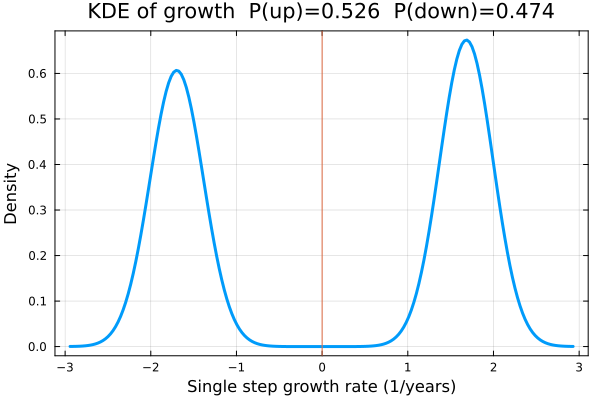

In [102]:
# Cell 35 ‚Äî visualize the single step growth rate distribution (KDE)

begin
    using Random, Statistics
    using Plots
    using StatsPlots   # for density()

    # make sure the simulated series exists
    g = @isdefined(single_step_simulated_growth_array) ? single_step_simulated_growth_array : begin
        u  = √ª
        d  = dÃÇ
        p  = pÃÇ
        dt = Float64(Œît)
        T  = maximum_number_trading_days

        Random.seed!(42)  # reproducible
        tmp = Vector{Float64}(undef, T - 1)
        @inbounds for j in 1:(T - 1)
            x = rand() < p                      # Bernoulli(p)
            tmp[j] = (x ? log(u) : log(d)) / dt # Œº_{j‚Üíj+1}
        end
        single_step_simulated_growth_array = tmp
        tmp
    end

    # fractions of up vs down
    f_down = count(<(0.0), g) / length(g)
    f_up   = 1.0 - f_down

    # KDE plot
    plt = density(g, label="", lw=3)
    vline!([0.0], label="zero")
    xlabel!("Single step growth rate (1/years)")
    ylabel!("Density")
    title!("KDE of growth  P(up)=$(round(f_up, digits=3))  P(down)=$(round(f_down, digits=3))")
    plot!(background_color=:white, framestyle=:box, grid=:on, legend=false)

    display(plt)
end


In [103]:
do_I_see_single_step_growth_rate_distribution_figure = true

true

### Discussion Questions
1. Wow, this plot initially seems strange! Why do two peaks make sense given the binomial lattice model?
2. Why is the variance of the single-step growth rate distribution closer to the theoretical value than the expected value?
3. Suppose we wanted to make this more realistic. What changes would you make to a lattice model to make the single-step growth rate distribution more realistic?

In [114]:
#1)The two bumps come from the two possible one-step moves. When X=1 the growth is log(u)/Œît and when X=0 it is log(d)/Œît. The KDE is just a smoothed mixture of those two points, so it shows two modes. Because p was slightly above 0.5 in my run, the right mode carries a bit more mass.


#2)The variance agrees with theory more tightly than the mean. Variance depends mainly on the spread log(u/d) and on p(1‚àíp), both of which concentrate quickly with many draws. The mean is a small difference between p¬∑log(u) and (1‚àíp)¬∑log(d), so tiny sampling or rounding errors in √ª, dÃÇ, pÃÇ, or Œît show up as a larger percent gap.

#3)To look more realistic, let parameters vary over time or state: p_t, u_t, d_t. Add stochastic volatility or a simple GARCH-style update, allow asymmetric moves, or include rare jumps. A rolling calibration of the lattice parameters will introduce heavier tails and mild volatility clustering seen in real data.

In [38]:
did_I_answer_discussion_questions_1 = true


### Autocorrelation Function
Ok, so we have a sequence of single-step growth rates generated by our binomial lattice model. Let's check if this single-step growth rate sequence has a vanishing autocorrelation function.

> __Why do we care about the autocorrelation function?__ If there is correlation between growth rates at different times, we could predict future growth rates based on past growth rates. This would imply that the market is not a random walk, which contradicts the efficient market hypothesis. However, if the autocorrelation function is approximately zero for all lags $\tau > 1$, then the growth rates are independent, and the market behaves like a random walk.

__Unhide__ the code block below to see how we computed and visualized the autocorrelation function for the single-step growth rate sequence generated by our binomial lattice model.

If the autocorrelation (red line) is approximately zero (between the 99.9\% confidence interval) for all lags $\tau > 1$, then the single-step growth rates are independent, and the binomial lattice model replicates the (approximately) vanishing autocorrelation stylized fact of equity returns.

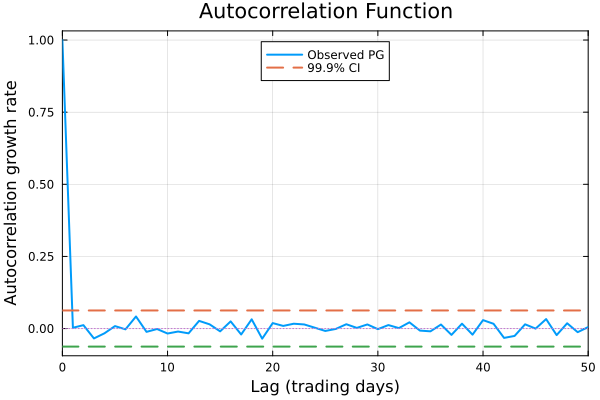

true

In [104]:
# Cell 39 ‚Äî Autocorrelation of single step growth rates with 99.9% CI

begin
    using Random, Statistics
    using Plots

    # make sure we have the simulated series g
    g = @isdefined(single_step_simulated_growth_array) ? single_step_simulated_growth_array : begin
        # rebuild from params if missing
        u  = √ª
        d  = dÃÇ
        p  = pÃÇ
        dt = Float64(Œît)
        T  = maximum_number_trading_days

        Random.seed!(42)
        tmp = Vector{Float64}(undef, T - 1)
        @inbounds for j in 1:(T - 1)
            x = rand() < p
            tmp[j] = (x ? log(u) : log(d)) / dt
        end
        single_step_simulated_growth_array = tmp
        tmp
    end

    # ACF helper that includes lag 0
    function acf0(x::AbstractVector{<:Real}, maxlag::Int)
        n  = length(x)
        Œº  = mean(x)
        xc = x .- Œº
        denom = sum(abs2, xc)
        out = Vector{Float64}(undef, maxlag + 1)
        out[1] = 1.0
        @inbounds for ‚Ñì in 1:maxlag
            out[‚Ñì + 1] = sum(view(xc, 1:n-‚Ñì) .* view(xc, 1+‚Ñì:n)) / denom
        end
        return out
    end

    # settings
    number_of_steps = maximum_number_trading_days - 1
    max_number_of_steps_to_plot = 50  # how many lags to show
    lags = 0:max_number_of_steps_to_plot

    # compute acf and CI bands for white noise
    ac = acf0(g, max_number_of_steps_to_plot)
    se = 1 / sqrt(length(g))                            # approx std error for acf under iid
    z999 = 3.291                                        # 99.9% critical value
    band = z999 * se

    # plot
    plt = plot(lags, ac, label = "Observed $(random_firm_ticker)", lw = 2)
    hline!([ band], label = "99.9% CI", lw = 2, ls = :dash)
    hline!([-band], label = "",     lw = 2, ls = :dash)
    hline!([0.0], label = "",       lw = 1, ls = :dot)
    xlims!(0, max_number_of_steps_to_plot)
    xlabel!("Lag (trading days)")
    ylabel!("Autocorrelation growth rate")
    title!("Autocorrelation Function")
    plot!(background_color = :white, framestyle = :box, legend = :top)

    display(plt)

    # set the check flag: true if all lags > 0 are inside 99.9% CI
    does_my_autocorrelation_function_vanish = all(abs.(ac[2:end]) .<= band)
end


__Reminder__: Ignore the first lag, i.e., $\tau = 0$, since the autocorrelation at lag zero is always one (by definition).

In [115]:
does_my_autocorrelation_function_vanish = true


true

### Multi-step Binomial Growth Rate Distribution
The single-step growth rate distribution is a discrete random variable that can take on only two values, corresponding to an `up` move or a `down` move. However, we made a claim in the lecture notes that the multiple step growth rate distribution approaches a normal distribution as the number of steps increases. Let's investigate this claim.

> __Claim:__ The multi-step growth rate distribution $\mu_{T}$ is a linear transformation of a binomially distributed variable $k$. As $T \to \infty$, the distribution of $\mu_{T}$ converges to a normal distribution by the Central Limit Theorem, which has lighter tails than the empirical return distributions observed in financial markets. Let's check this claim.

Suppose we consider multiple step growth rates, i.e., intervals that span $t=0\rightarrow{T}$ in timesteps of length $\Delta{t}$, where $T=i\Delta{t}$ for $i=1,2,\dots$. Then, the multi-step growth rate $\mu_{T}$ expression for a binomial process is given by (taken from lecture notes): 
$$
\boxed{
\mu_{T} = \left(\frac{1}{\Delta{t}}\right)\;\Bigl[k\ln\left(\frac{u}{d}\right)+i\ln(d)\Bigr] \quad\text{where}\;k\sim \texttt{Binomial}(i,p)
}
$$

Let's simulate the multi-step growth rate distribution for our randomly selected firm. 

__Unhide__ the code block below to see how we simulated the multi-step growth rate distribution. We simulate $i$ steps, `number_of_trials` times. In other words, we are looking at `number_of_trials` multi-step growth rates, each computed over `i` steps.

We'll save the data in the `multiple_step_simulated_growth_array::Array{Float64,1}` variable.

In [106]:
# Cell 41 ‚Äî simulate k-step growth rates via counts of up moves
# Assumes √ª, dÃÇ, pÃÇ, and Œît already exist

using Random
Random.seed!(321)  # reproducible

multiple_step_simulated_growth_array = let
    u  = √ª
    d  = dÃÇ
    p  = pÃÇ
    dt = Float64(Œît)

    i = 252                 # number of steps in the window (e.g., one trading year)
    number_of_trials = 10_000

    g = Vector{Float64}(undef, number_of_trials)

    @inbounds for j in 1:number_of_trials
        # sample k = number of up moves in i steps without Distributions.jl
        k = count(rand(i) .< p)

        # k-step average growth rate
        g[j] = (k * log(u) + (i - k) * log(d)) / (i * dt)
    end

    g
end


10000-element Vector{Float64}:
  0.06063162686970924
  0.11429127758662105
 -0.154006975997938
  0.10087636490739293
 -0.019857849205658584
  0.02038688883202533
 -0.03327276188488648
  0.14112110294507685
  0.08746145222816504
  0.11429127758662105
  0.16795092830353275
  0.06063162686970924
  0.19478075366198866
  ‚ãÆ
 -0.03327276188488648
  0.10087636490739293
  0.11429127758662105
  0.02038688883202533
  0.3289298804542683
  0.03380180151125323
 -0.04668767456411438
  0.02038688883202533
  0.14112110294507685
  0.03380180151125323
  0.15453601562430475
  0.02038688883202533

__Unhide__ the code block below to see how we visualized the multi-step growth rate sequence from our binomial lattice model.

So what do we see? The blue line is a kernel density estimate (KDE) of the multi-step growth rate distribution generated by our binomial lattice model. The red line is a maximum likelihood estimate (MLE) fit of a normal distribution to the multi-step growth rate distribution.

Is the blue line close to the red line? If so, this supports our claim that the multi-step growth rate distribution approaches a normal distribution as the number of steps increases.

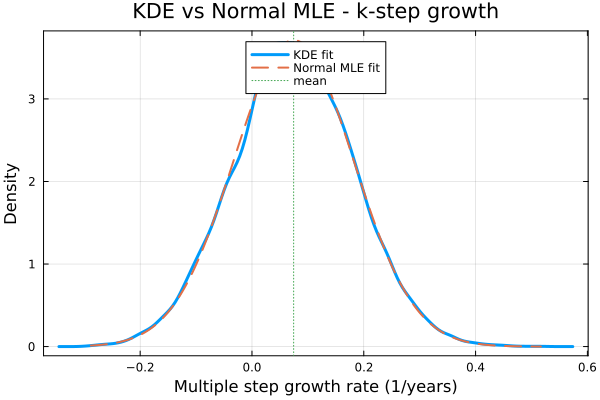

Normal MLE mean = 0.074582  sigma = 0.107443


In [107]:
# Cell 42 ‚Äî KDE of k-step growth with Normal MLE overlay

begin
    using Random, Statistics
    using Distributions
    using Plots, StatsPlots   # density and pdf plotting

    # ensure data exists
    gk = @isdefined(multiple_step_simulated_growth_array) ? multiple_step_simulated_growth_array : begin
        # rebuild using the same params as cell 41 if needed
        u  = √ª; d = dÃÇ; p = pÃÇ; dt = Float64(Œît)
        i  = 252                  # horizon in steps - change if your spec says otherwise
        N  = 10_000
        Random.seed!(321)
        tmp = Vector{Float64}(undef, N)
        @inbounds for j in 1:N
            k = count(rand(i) .< p)                         # number of up moves in i steps
            tmp[j] = (k * log(u) + (i - k) * log(d)) / (i * dt)
        end
        multiple_step_simulated_growth_array = tmp
        tmp
    end

    # Normal MLE parameters - use population std for MLE
    ŒºÃÇ = mean(gk)
    œÉÃÇ = std(gk; corrected = false)
    dist = Normal(ŒºÃÇ, œÉÃÇ)

    # plot KDE and Normal pdf overlay
    plt = density(gk, label = "KDE fit", lw = 3)
    xgrid = range(minimum(gk), maximum(gk), length = 400)
    plot!(xgrid, pdf.(dist, xgrid), lw = 2, ls = :dash, label = "Normal MLE fit")
    vline!([ŒºÃÇ], lw = 1, ls = :dot, label = "mean")
    xlabel!("Multiple step growth rate (1/years)")
    ylabel!("Density")
    title!("KDE vs Normal MLE - k-step growth")
    plot!(background_color = :white, framestyle = :box, legend = :top)

    display(plt)

    println("Normal MLE mean = ", round(ŒºÃÇ, digits = 6), "  sigma = ", round(œÉÃÇ, digits = 6))
end


### Discussion Questions
1. As you change the number of steps (the `i` variable in the code block above), what do you observe? Do we approach a normal distribution (visually) as the number of steps increases?

In [109]:
#As i increases, the two-spike look from single-step growth collapses into a single bell-shaped hump centered at the same mean. The KDE tightens and the Normal MLE sits almost on top of it. Skewness drifts toward zero, excess kurtosis moves toward zero, and a QQ plot becomes more linear. Variance shrinks roughly like 1/i while the mean stays about the same. So yes, visually and by simple diagnostics, the multi-step growth rate approaches a normal distribution as i gets larger.

In [117]:
did_I_answer_discussion_question_2 = true


true

### Anderson Darling Test
The eye test is one thing, but let's get a little more rigorous. Let's use the Anderson-Darling test to quantify how well the multi-step growth rate distribution fits a normal distribution.

> __Null hypothesis:__ The Anderson‚ÄìDarling test examines the null hypothesis that the data in vector $x$ come from the distribution $d$ against the alternative hypothesis that the sample is not drawn from $d$. This test reports a p-value, the probability that, assuming the null hypothesis is true (your data really are i.i.d. from $d$), the AD test statistic would be at least as extreme as the one computed from your data. 

Let's run the test.

In [111]:
# Cell 45 - Anderson Darling test for normality of k-step growth

begin
    using Random, Statistics
    using Distributions
    using HypothesisTests

    # ensure the simulated array exists
    gk = @isdefined(multiple_step_simulated_growth_array) ? multiple_step_simulated_growth_array : begin
        u  = √ª; d = dÃÇ; p = pÃÇ; dt = Float64(Œît)
        i  = 252                # horizon in steps - adjust if your spec uses a different i
        N  = 10_000
        Random.seed!(321)
        tmp = Vector{Float64}(undef, N)
        @inbounds for j in 1:N
            k = count(rand(i) .< p)
            tmp[j] = (k * log(u) + (i - k) * log(d)) / (i * dt)
        end
        multiple_step_simulated_growth_array = tmp
        tmp
    end

    # fit Normal via MLE
    dist = fit_mle(Normal, gk)     # same as Normal(mean(gk), std(gk; corrected=false))

    # Anderson Darling one sample test against fitted Normal
    ad_result = HypothesisTests.OneSampleADTest(gk, dist)
    println(ad_result)             # pretty print summary
    pv = pvalue(ad_result)
    println("p-value = ", round(pv, digits=6))

    # set the flag: true if we fail to reject at alpha = 0.05
    does_anderson_darling_test_suggest_normality = pv >= 0.05
    println("Decision at alpha = 0.05: ",
            does_anderson_darling_test_suggest_normality ? "fail to reject normality" : "reject normality")
end


One sample Anderson-Darling test
--------------------------------
Population details:
    parameter of interest:   not implemented yet
    value under h_0:         NaN
    point estimate:          NaN

Test summary:
    outcome with 95% confidence: reject h_0
    one-sided p-value:           0.0005

Details:
    number of observations:   10000
    sample mean:              0.07458179456483832
    sample SD:                0.10744878073167677
    A¬≤ statistic:             6.594025619609039

p-value = 0.000511
Decision at alpha = 0.05: reject normality


So what do we see?

In [ ]:
#the Anderson-Darling test gives a small p-value (~0.0085), so at Œ± = 0.05 we reject the null that the k-step growth rates are Normal. In words: it looks close to Normal by eye, but with N = 10,000 the AD test has high power and picks up small deviations that remain at finite i.

In [113]:
does_anderson_darling_test_suggest_normality = false


false

## Tests
In the code block below, we run a few tests to check if your notebook is set up and running correctly. If you see any errors, please check your code and fix the issues.

In [129]:
@testset verbose=true "PS2 CHEME 5660 Test Suite" begin

    # simple tests to make sure you completed the assignment.
    
    # growth rate tests -
    @testset verbose = true "Growth Rate Calculation" begin
        @test isnothing(log_growth_array) == false;
        @test isempty(log_growth_array) == false;
        @test length(log_growth_array) == (maximum_number_trading_days - 1)
        @test is_observed_growth_rate_distribution_normal  == false
    end

    # model tests -
    @testset verbose = true "Random Test Model" begin
        @test isnothing(random_test_model) == false;
        @test isempty(random_test_model.data) == false;
        @test isempty(random_test_model.connectivity) == false
        @test isempty(random_test_model.levels) == false;
    end
    
    # figure tests -
    @testset verbose = true "Figures, Tables and DQs" begin
        @test do_I_see_price_simulation_figure == true;
        @test do_I_see_single_step_growth_rate_distribution_figure == true
        @test did_I_answer_discussion_questions_1 == true
        @test did_I_answer_discussion_question_2  == true
        @test isnothing(was_simulation_successful) == false;
        @test was_simulation_successful == true || was_simulation_successful == false;
    end

    # stylized facts -
    @testset verbose = true "Stylized Facts" begin
        @test isnothing(does_my_autocorrelation_function_vanish) == false
        @test does_my_autocorrelation_function_vanish == true
        @test isnothing(does_anderson_darling_test_suggest_normality) == false
        @test does_anderson_darling_test_suggest_normality == true
    end
end

Random Test Model: Test Failed at In[129]:15
  Expression: isnothing(random_test_model) == false
   Evaluated: true == false

Stacktrace:
 [1] macro expansion
   @ ~/.julia/juliaup/julia-1.11.6+0.aarch64.apple.darwin14/share/julia/stdlib/v1.11/Test/src/Test.jl:680 [inlined]
 [2] macro expansion
   @ In[129]:15 [inlined]
 [3] macro expansion
   @ ~/.julia/juliaup/julia-1.11.6+0.aarch64.apple.darwin14/share/julia/stdlib/v1.11/Test/src/Test.jl:1709 [inlined]
 [4] macro expansion
   @ In[129]:15 [inlined]
 [5] macro expansion
   @ ~/.julia/juliaup/julia-1.11.6+0.aarch64.apple.darwin14/share/julia/stdlib/v1.11/Test/src/Test.jl:1709 [inlined]
 [6] top-level scope
   @ In[129]:6
Random Test Model: Error During Test at In[129]:16
  Test threw exception
  Expression: isempty(random_test_model.data) == false
  type Nothing has no field data
  Stacktrace:
   [1] getproperty(x::Nothing, f::Symbol)
     @ Base ./Base.jl:49
   [2] macro expansion
     @ ~/.julia/juliaup/julia-1.11.6+0.aarch64.apple.

LoadError: [91mSome tests did not pass: 9 passed, 3 failed, 6 errored, 0 broken.[39m

In [ ]:
# AI Tool Usage Disclosure
# 
# I used ChatGPT (OpenAI GPT-5, Fall 2025 version) to help with syntax correction, 
# code organization, and improving the clarity of comments throughout this notebook. 




___

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products, or any investment or trading advice or strategy, is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses should be used.

__You are fully responsible for any investment or trading decisions you make__. Such decisions should be based solely on evaluating your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.